In [1]:
from albumentations.pytorch.transforms import ToTensorV2
from engine import train_one_epoch, evaluate

import matplotlib.pyplot as plt
import albumentations as A
import pandas as pd
import torchvision
import numpy as np
import torch
import cv2
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **1.** Готовим данные

In [6]:
train_csv_path = '../data/train_dataset.csv'
valid_csv_path = '../data/validation_dataset.csv'

train_images = '../data/fire_smoke_dataset/train'
valid_images = '../data/fire_smoke_dataset/valid'

In [7]:
train_df = pd.read_csv(train_csv_path)
validation_df = pd.read_csv(valid_csv_path)

In [8]:
# Define categories
categories = train_df['class'].unique()
print(categories)

['smoke' 'fire']


In [9]:
class LabelMap:
    def __init__(self, categories):     
        self.map_dict = {}
        self.reverse_map_dict = {}
        for i, cat in enumerate(categories):
            self.map_dict[cat] = i + 1
            self.reverse_map_dict[i] = cat

    def fit(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df

def encode_label(df, column, map_dict):
    df[column] = df[column].map(map_dict)
    return df

In [10]:
label_map = LabelMap(categories)

full_train = encode_label(train_df, 'class', label_map.map_dict)
full_validation = encode_label(validation_df, 'class', label_map.map_dict)

## **2.** Готовим датасет

In [11]:
class FireDataset(torch.utils.data.Dataset):

    def __init__(self, df, image_path, transforms=None, **kwargs):
        super().__init__(**kwargs)
        self.df         = df
        self.image_path = image_path
        self.images     = self.df['filename'].unique()
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): 
        if self.images[idx][-4:] != '.jpg':
            image_file = self.image_path + '/' + self.images[idx] + '.jpg'
        else:
            image_file = self.image_path + '/' + self.images[idx]
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = img.astype(np.float32) / 255.0  
 
        image_data = self.df[self.df['filename'] == self.images[idx]]
        xmins = image_data['xmin'].values
        ymins = image_data['ymin'].values
        xmaxs = image_data['xmax'].values
        ymaxs = image_data['ymax'].values
        
        boxes = torch.as_tensor(np.stack([xmins, ymins, xmaxs, ymaxs], axis=1), dtype=torch.float32)
        labels = torch.as_tensor(image_data['class'].values, dtype=torch.int64)
        image_id = torch.tensor([idx])
        
        areas = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id 
        target['area'] = areas  
        target['iscrowd'] = iscrowd 

        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = transformed['image'] 
            target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            
        return torch.as_tensor(img, dtype=torch.float32), target

In [12]:
# Добавим рандомное изменение яркости и контрастности на обучающей выборки, для улчшения обучения.

transform_train = A.Compose([
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2(p=1)], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

transform_valid = A.Compose([
    ToTensorV2(p=1)], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = FireDataset(full_train, train_images, transform_train)
valid_dataset = FireDataset(full_validation, valid_images, transform_valid)

data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
data_loader_valid = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

## **3.** Смотрим на картинки

In [14]:
def plot_images(images, targets):
    count_imgs = 0
    for image, target in zip(images, targets):

        if count_imgs == 3:
            break

        count_imgs += 1
        sample = image.squeeze().permute(1,2,0).cpu().numpy()
        boxes  = target['boxes'].cpu().numpy().astype(np.int32)
        _, ax = plt.subplots(1, 1, figsize=(10, 8))

        target = target['labels'].tolist()
        for targ, box in zip(target, boxes):

            cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (1,0,0), 2)
                           
            cv2.putText(sample, label_map.reverse_map_dict[targ - 1], 
                        (box[0], box[1] - 10),
                        cv2.FONT_HERSHEY_DUPLEX,
                        0.5, (230,23,44), 1)
            
        ax.set_axis_off()
        ax.imshow((sample * 255).astype(np.uint8))

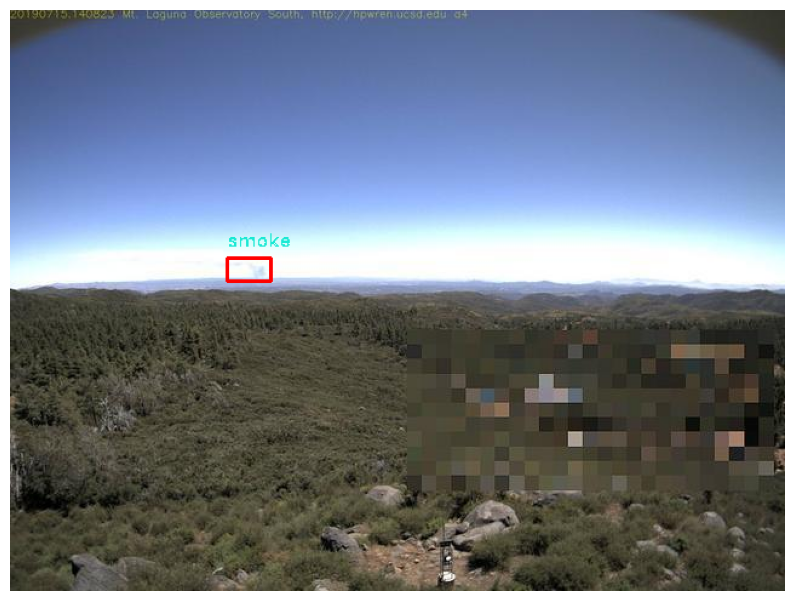

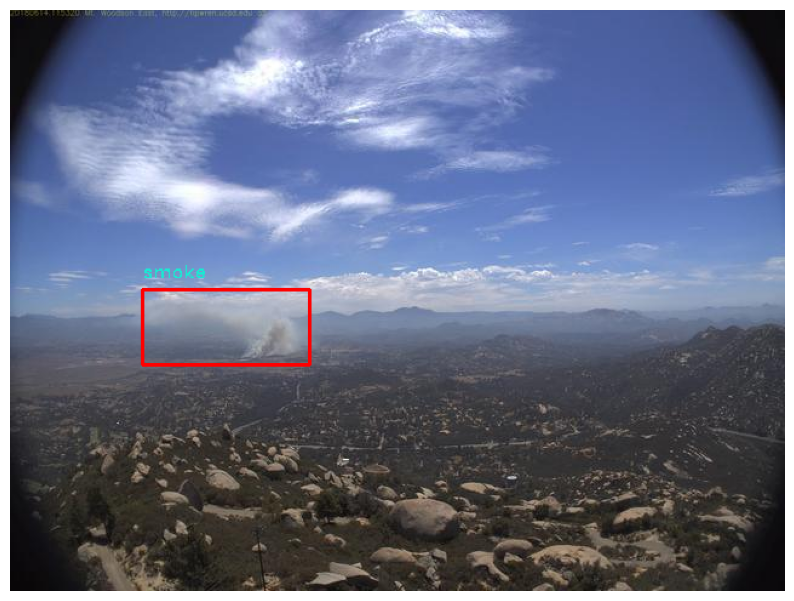

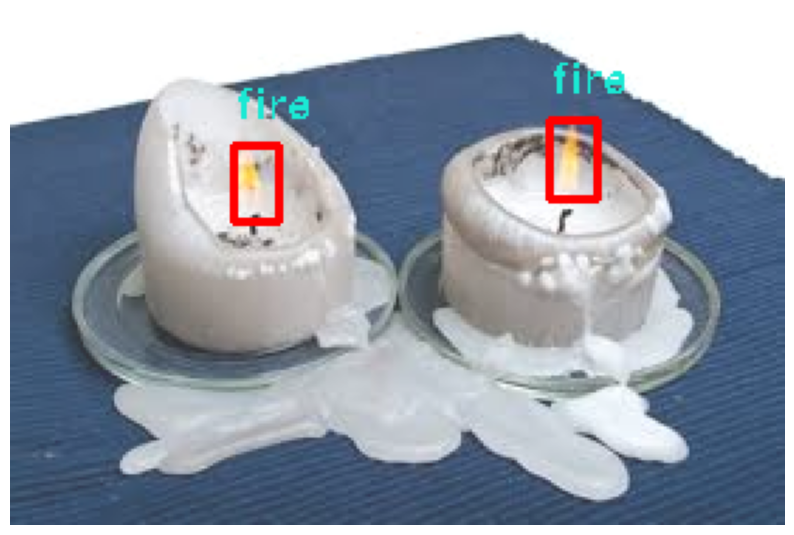

In [15]:
images, targets = next(iter(data_loader_train))
plot_images(images, targets)

## **4.** Инициализируем модель

In [16]:
# Загружаем модель Fast R-CNN предобученную на COCO датасете
# с backbone в виде resnet50, предобученным на ImageNet

detection_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = detection_model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
detection_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, len(categories) + 1)
detection_model = detection_model.to(device)
device

c:\Users\Даня\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Даня\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


device(type='cuda')

## **5.** Тренируем модель

In [17]:
def training(model, train_loader, val_loader, epochs):
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(epochs):

        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=len(data_loader_train))
        lr_scheduler.step()

        evaluate(model, val_loader, device=device)

training(detection_model, data_loader_train, data_loader_valid, epochs=4)

Epoch: [0]  [  0/232]  eta: 0:14:01  lr: 0.000027  loss: 1.4115 (1.4115)  loss_classifier: 1.2706 (1.2706)  loss_box_reg: 0.1000 (0.1000)  loss_objectness: 0.0372 (0.0372)  loss_rpn_box_reg: 0.0036 (0.0036)  time: 3.6272  data: 0.0195  max mem: 5085
Epoch: [0]  [231/232]  eta: 0:00:00  lr: 0.005000  loss: 0.1601 (0.2805)  loss_classifier: 0.0562 (0.1353)  loss_box_reg: 0.0902 (0.1180)  loss_objectness: 0.0029 (0.0215)  loss_rpn_box_reg: 0.0033 (0.0058)  time: 0.3083  data: 0.0162  max mem: 8196
Epoch: [0] Total time: 0:01:13 (0.3172 s / it)
creating index...
index created!
Test:  [ 0/60]  eta: 0:00:10  model_time: 0.1596 (0.1596)  evaluator_time: 0.0050 (0.0050)  time: 0.1826  data: 0.0160  max mem: 8196
Test:  [59/60]  eta: 0:00:00  model_time: 0.1221 (0.1253)  evaluator_time: 0.0030 (0.0035)  time: 0.1420  data: 0.0128  max mem: 8196
Test: Total time: 0:00:08 (0.1455 s / it)
Averaged stats: model_time: 0.1221 (0.1253)  evaluator_time: 0.0030 (0.0035)
Accumulating evaluation results..

In [18]:
# Сохраняем модель
model_name = 'detection_model.pt'
torch.save(detection_model.state_dict(), model_name)

## **6.** Смотрим на предсказания

In [19]:
detection_model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [20]:
def view_sample(loader, model, device, threshold):

    images, targets = next(iter(loader))
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes_gt = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    model.to(device)
    model.eval()
    cpu_device = torch.device('cpu')

    outputs = model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    _, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes_gt:
        color_red = (1,0,0)
        cv2.rectangle(sample,
              (box[0], box[1]),
              (box[2], box[3]),
              color_red, 2)
             
    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()
    targets = outputs[0]['labels'].tolist()      

    pred_box_count = 0

    
    for box, p, target in zip(boxes, scores, targets):        
        if p > threshold:
            pred_box_count += 1
            cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  (0,2,0), 2)
            
            cv2.putText(sample, label_map.reverse_map_dict[target - 1], 
            (int(box[0]), int(box[1] - 10)),
            cv2.FONT_HERSHEY_DUPLEX,
            1, (243,126,126), 1)
                    
    ax.set_axis_off()
    ax.imshow((sample * 255).astype(np.uint8))      

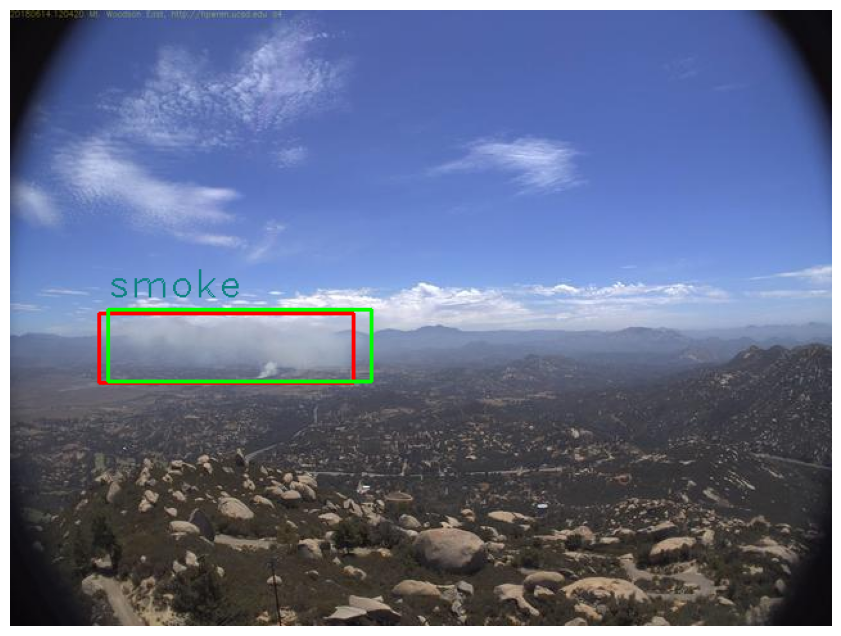

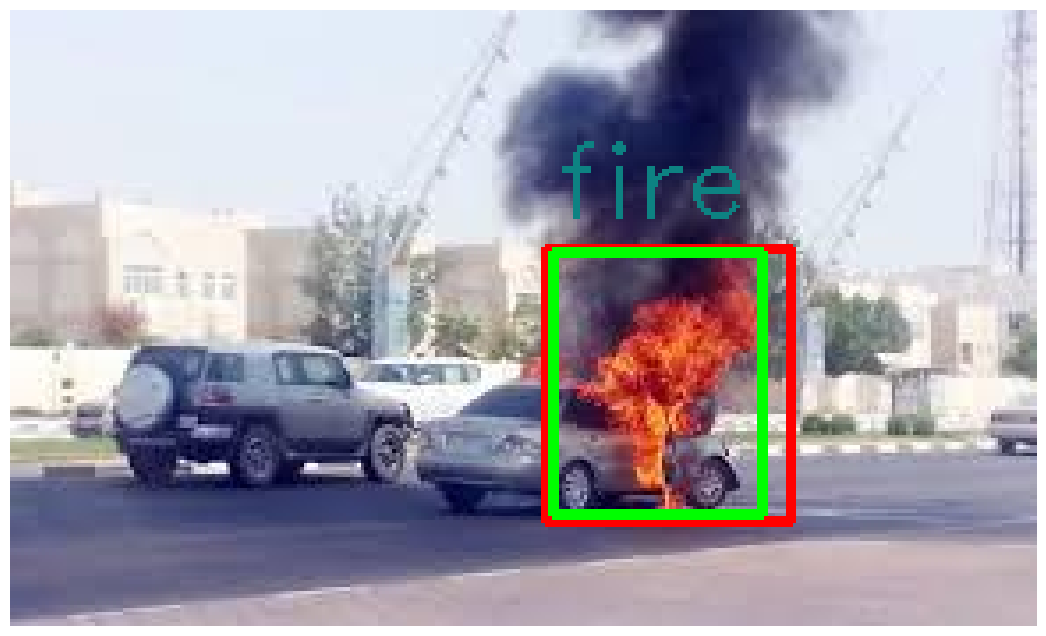

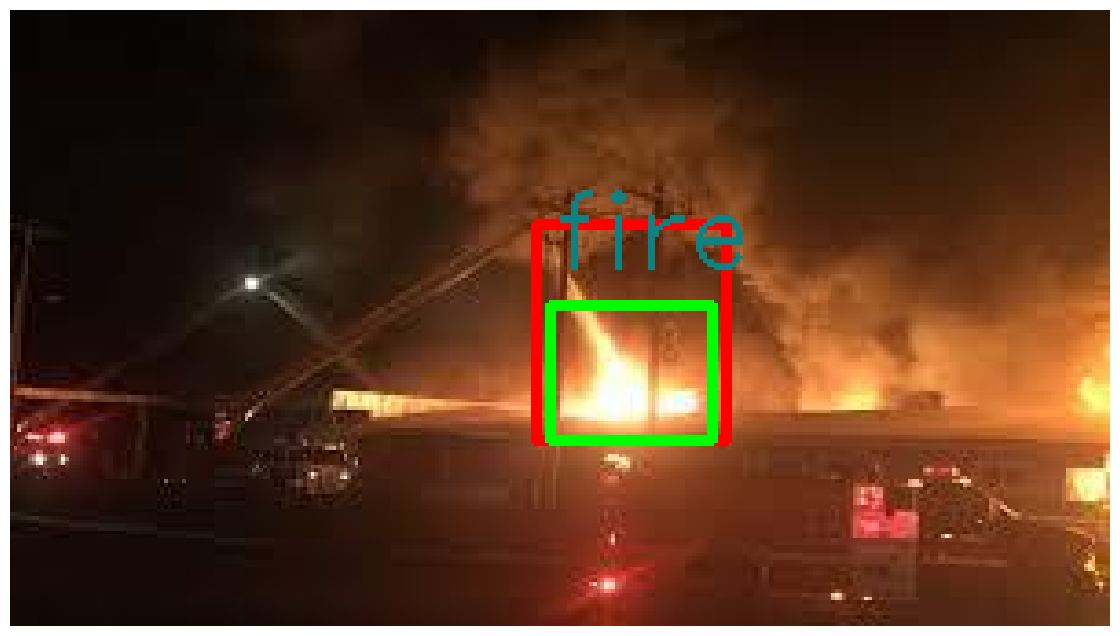

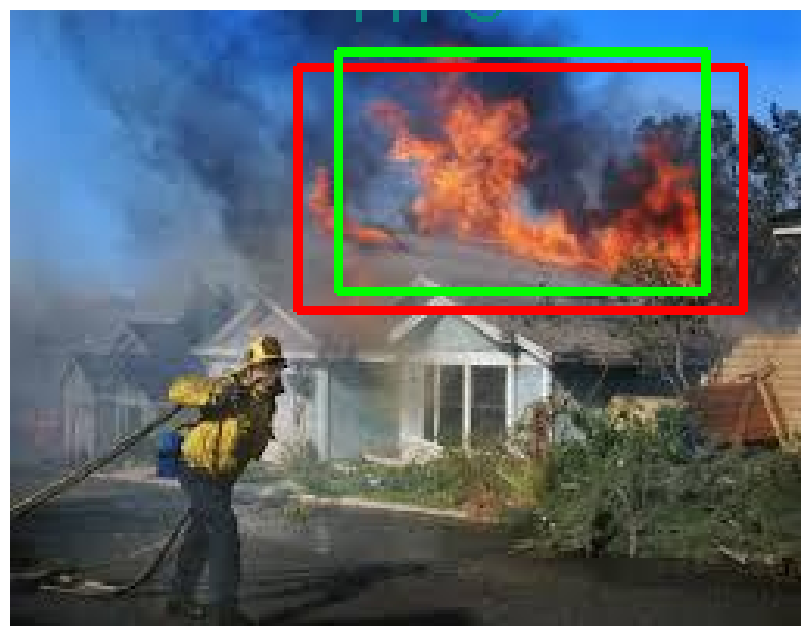

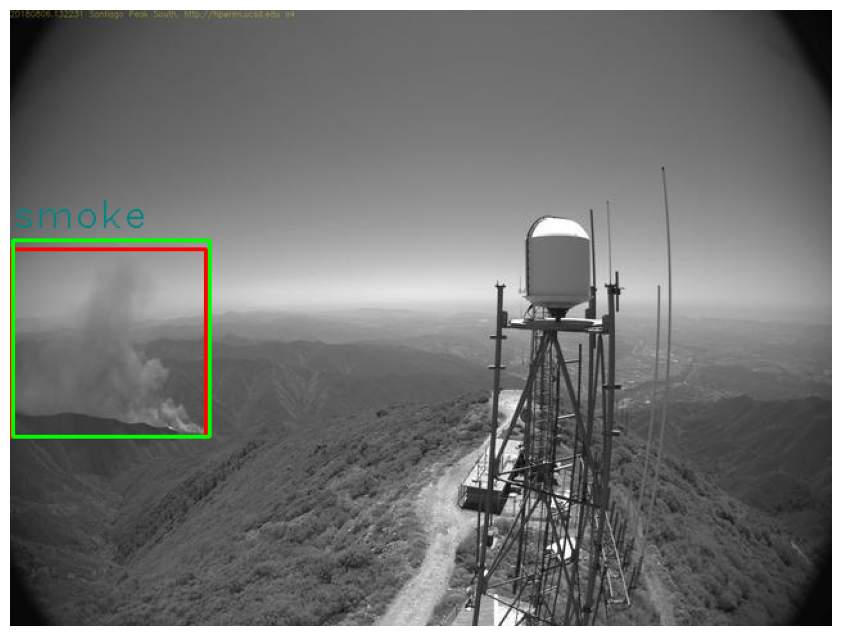

In [22]:
# Show predictions
for i in range(5):
    view_sample(data_loader_valid, detection_model, device, 0.8)

## **8.** Сссылки

[**1**] PyTorch - Функции для детектирования - https://github.com/pytorch/vision/tree/main/references/detection<br>
[**2**] PyTorch - Туториал по детектированию объектов - https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html<br>
